In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from PIL import Image
import math
import torch.nn.functional as F
import json
from scipy.optimize import linear_sum_assignment
import pycocotools.mask as mask_util
import re
import glob
from tqdm.notebook import tqdm
import cv2
import pycocotools.mask as mask_utils
from torchvision.ops import masks_to_boxes
import torch.distributions as dist

from mmcv.cnn.utils.flops_counter import add_flops_counting_methods, flops_to_string, params_to_string

/home/karan/anaconda3/envs/tr/lib/python3.11/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
class AddPoissonNoise(object):
    def __init__(self, intensity=0.5):
        self.intensity = intensity
        
    def __call__(self, tensor):
        
        # Create a Poisson distribution with the specified intensity
        poisson = dist.Poisson(self.intensity)

        # Generate random noise with the same size as the image
        noise = poisson.sample(tensor.size())

        # Add the noise to the image
        noisy_image = tensor + noise

        # Clip the image to ensure pixel values are within the valid range
        noisy_image = torch.clamp(noisy_image, 0, 1)

        # Convert the noisy image back to the original data type
        noisy_image = noisy_image.type(tensor.dtype)

        return noisy_image
    
    def __repr__(self):
        return self.__class__.__name__ + '(intensity={0})'.format(self.intensity)

In [4]:
def get_args_parser():
    
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=150, type=int)
    parser.add_argument('--lr_drop', default=100, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--model_path', type=str, default=None,
                        help="Path to the model weights.")
    # * Backbone
    parser.add_argument('--backbone', default='resnet101', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=384, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_frames', default=36, type=int,
                        help="Number of frames")
    parser.add_argument('--num_ins', default=1, type=int,
                        help="Number of instances")
    parser.add_argument('--num_queries', default=36, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    parser.add_argument('--no_labels_loss', dest='labels_loss', action='store_false',
                        help="Enables labels losses")
    parser.add_argument('--no_boxes_loss', dest='boxes_loss', action='store_false',
                        help="Enables bounding box losses")
    parser.add_argument('--no_L1_loss', dest='L1_loss', action='store_false',
                        help="Enables L1 losses for bboxes")
    parser.add_argument('--no_giou_loss', dest='giou_loss', action='store_false',
                        help="Enables Generalized IOU losses for bboxes")
    parser.add_argument('--no_focal_loss', dest='focal_loss', action='store_false',
                        help="Enables Focal losses for mask")
    parser.add_argument('--no_dice_loss', dest='dice_loss', action='store_false',
                        help="Enables dice losses for mask")
    
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--img_path', default='data/ytvos/valid/JPEGImages/')
    parser.add_argument('--ann_path', default='data/ytvos/annotations/instances_val_sub.json')
    parser.add_argument('--save_path', default='results.json')
    parser.add_argument('--dataset_file', default='ytvos')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='output_ytvos',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    #parser.add_argument('--eval', action='store_true')
    parser.add_argument('--eval', action='store_false')
    parser.add_argument('--num_workers', default=0, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser


In [5]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b.cpu() * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def get_bbox(mask_list):
    return torch.cat([masks_to_boxes(mask) for mask in mask_list], dim=0)

pat=re.compile("(\d+)\D*$")

def key_func(x):
    mat=pat.search(os.path.split(x)[-1]) # match last group of digits
    if mat is None:
        return x
    return "{:>10}".format(mat.group(1)) # right align to 10 digits

def get_metric(pred, truth):
    # Sensitivity == Recall
    SE = PC = F1 = DC = 0
    
    # SR : Segmentation Result
    # GT : Ground Truth
    SR, GT = pred, truth

    # TP : True Positive
    TP = ((SR==1)&(GT==1)).sum().item()

    # FN : False Negative
    FN = ((SR==0)&(GT==1)).sum().item()

    # FP : False Positive
    FP = ((SR==1)&(GT==0)).sum().item()

    Inter = TP
    Union = SR.sum().item() + GT.sum().item()
    SE = float(TP)/(float(TP+FN) + 1e-6) #Recall
    PC = float(TP)/(float(TP+FP) + 1e-6) #Precision
    F1 = 2*SE*PC/(SE+PC + 1e-6) #F1 Score
    DC = float(2*Inter)/(float(Union) + 1e-6) #Dice Score

    return np.array([SE, PC, F1, DC])

In [6]:
def create_pred_video(img, msk, type_ = None):
    if not isinstance(img, np.ndarray): img = np.array(img)
    if not isinstance(msk, np.ndarray): msk = np.array(msk)
    if img.dtype!='uint8': img= (img*255).astype(np.uint8)
    if msk.dtype!='uint8': msk= (msk*255).astype(np.uint8)
    if(len(img.shape)<3): img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    cnts = cv2.findContours(msk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if type_ == 'GT':
        for c in cnts:
            cv2.drawContours(img, [c], -1, (0, 255, 0), thickness=2)
    if type_ == 'Pred':
        for c in cnts:
            cv2.drawContours(img, [c], -1, (0, 0, 255), thickness=2)
    return img

In [49]:
parser = argparse.ArgumentParser('VisTR Inference script',
                                 parents=[get_args_parser()])
args = parser.parse_args("")
args.num_classes = 41

if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

args.masks = True
args.device = 'cuda:0'

#change these to 1 & 36
args.num_ins = 1
args.num_queries = 36
args.num_frames = 36

device = torch.device(args.device)
# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [50]:
args.model_path = 'r101_vistr/checkpoint0003.pth'

with torch.no_grad():
    model, criterion, postprocessors = build_model(args)
    state_dict = torch.load(args.model_path,  map_location='cpu')['model']
    model.load_state_dict(state_dict)
    model.to(device)

/home/karan/anaconda3/envs/tr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/karan/anaconda3/envs/tr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
test_file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/Test/*'))
test_file_dir

test_img_path = []
test_msk_path = []

num_frames = args.num_frames
num_ins = args.num_ins

for path in test_file_dir:
    test_img_path.append(sorted(glob.glob(path+'/*_0001_IMAGES/images/*.jpg'), key=key_func))
    test_msk_path.append(sorted(glob.glob(path+'/*_0001_IMAGES/masks/*.png'), key=key_func))

In [10]:
# with torch.no_grad():
#     model, criterion, postprocessors = build_model(args)
#     state_dict = torch.load(args.model_path,  map_location='cpu')['model']
#     model.load_state_dict(state_dict)
#     model.to(device)
    
# n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('number of params:', n_parameters)

In [11]:
def get_pred(model, image):
    
    model.eval()
    with torch.no_grad():
        return model(image)

In [28]:
def test_model(img_path, num, model, n_frames = args.num_frames):
    
#     model = add_flops_counting_methods(model)
    vid = img_path[num]
    vid_length = len(vid)
#     vid_length = 40

    pred_masks_seq_2 = []
    pred_score_2 = []

    im = Image.open(img_path[0][0])

#     for i in tqdm(range(0, 40 ,n_frames), desc = 'Testing', leave = False):
    for i in tqdm(range(0, vid_length ,n_frames), desc = 'Testing', leave = False):
        start = i
        end = min(i+n_frames,vid_length)
        image = [transform(Image.open(frame)) for frame in vid[start:end]]
#         print(image[0].size())
        if image[0].size()[0] != 3:
            image = [img.repeat(3,1,1).unsqueeze(0).to(device) for img in image]
        else:
            image = [img.unsqueeze(0).to(device) for img in image]
        image = torch.cat(image,dim=0)
        clip_len = end - start
        if clip_len < n_frames:
            image = torch.cat([image for _ in range(math.ceil(n_frames/clip_len))],dim=0)
            image = image[:n_frames]
#         model.start_flops_count()
#         start = time.time()
        outputs = get_pred(model, image)
#         end = time.time()
#         tim.append(len(imgs)/(end-start))
#         AVG_flops, params_count = model.compute_average_flops_cost()
#         print('Average flops',flops_to_string(AVG_flops))
#         print('Parameters',params_to_string(params_count))
#         model.stop_flops_count()
        # end of model inference
        logits, boxes, masks = outputs['pred_logits'].softmax(-1)[0,:,:-1], outputs['pred_boxes'][0], outputs['pred_masks'][0]
        pred_masks = F.interpolate(masks.reshape(n_frames,num_ins,masks.shape[-2],masks.shape[-1]),(im.size[1],im.size[0]),mode="bilinear").sigmoid().cpu().detach().numpy()>0.5
        pred_logits = logits.reshape(n_frames,num_ins,logits.shape[-1]).cpu().detach().numpy()
        pred_masks = pred_masks[:clip_len]
        pred_logits = pred_logits[:clip_len]
        pred_scores = np.max(pred_logits,axis=-1)
        pred_logits = np.argmax(pred_logits,axis=-1)
        temp = []
        for m in range(num_ins):
            if pred_masks[:,m].max()==0:
                continue
            score = pred_scores[:,m].mean()
            #category_id = pred_logits[:,m][pred_scores[:,m].argmax()]
            category_id = np.argmax(np.bincount(pred_logits[:,m]))
            instance = {'score':float(score), 'category_id':int(category_id)}
            temp.append(instance)
        pred_score_2.append(temp)
        pred_masks_seq_2.append(pred_masks)
    pred_final_2 = [img[0] for batch in pred_masks_seq_2 for img in batch]
    return pred_final_2, vid_length

In [13]:
# threshold
def get_bbox(gray):
    
    bbox=[]
    if not isinstance(gray, np.ndarray): gray = np.array(gray)
    if gray.dtype!='uint8': gray= (gray*255).astype(np.uint8)
        
#     img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

    # get contours
#     result = img.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        bbox.append([x,y,w,h])
#         cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
#         print("x,y,w,h:",x,y,w,h)
    return bbox

In [14]:
def get_filtered_mask(mask_clip):
    bbox =[None]*len(mask_clip)
    cntr = [None]*len(mask_clip)
    area = [None]*len(mask_clip)
    filtered_mask = []
    for i in range(len(mask_clip)):
        frame = mask_clip[i].astype('int')
        temp = np.zeros_like(frame)

        blist = get_bbox(frame)

        if len(blist) == 0:
            temp = filtered_mask[-1]
        elif len(blist) == 1:
            x,y,w,h = blist[0]
            cntr[i] = (x+w/2, y+h/2)
            bbox[i] = (x,y,w,h)
    #         area[i] = frame[x:x+w, y:y+h]
            temp = frame
        elif len(blist) > 1:
            all_cntrs=[(x+w/2, y+h/2) for x,y,w,h in blist]
            area = [w*h for x,y,w,h in blist]
            if cntr[i-1] == None:
                index = np.argmax(area)
                cntr[i] = all_cntrs[index]
                bbox[i] = blist[index]
                x,y,w,h = blist[index]
                temp[y:y+h ,x:x+w] = frame[y:y+h ,x:x+w]
            else:
                x0, y0 = cntr[i-1]
                index = np.argmin([np.sqrt((x0-x)**2 + (y0-y)**2) for x,y in all_cntrs])
                cntr[i] = all_cntrs[index]
                bbox[i] = blist[index]
                x,y,w,h = blist[index]
                temp[y:y+h ,x:x+w] = frame[y:y+h ,x:x+w]
        filtered_mask.append(temp)
        
    return filtered_mask

In [38]:
# weights_path = sorted(glob.glob("r101_vistr/no_dice_loss/*.pth"))[1:]
# # weights_path = sorted(glob.glob("r101_vistr/no_giou_loss/*.pth"))[1:]
# # args.giou_loss = False

# # weights_path = sorted(glob.glob("r101_vistr/no_focal_loss/*.pth"))[1:]
# # args.focal_loss = False

# # weights_path = sorted(glob.glob("r101_vistr/no_L1_loss/*.pth"))[1:]
# # args.L1_loss = False

# # weights_path = sorted(glob.glob("r101_vistr/no_L1_loss/*.pth"))[1:]
# # args.L1_loss = False

# for path in weights_path:
#     args.model_path = path
    
#     with torch.no_grad():
#         model, criterion, postprocessors = build_model(args)
#         state_dict = torch.load(args.model_path,  map_location='cpu')['model']
#         model.load_state_dict(state_dict)
#         model.to(device)
        
#     transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize([0.2316], [0.2038]), #mean #standard deviation
# #     AddGaussianNoise(mean=0., std=std)
#     ])
#     test_res = []
#     pred_mask = []
    
#     for num in tqdm(range(len(test_img_path)), leave = False):
#     #     start = time.time()
#         output, vid_length = test_model(test_img_path, num, model, num_frames)
#     #     end = time.time()
#     #     print(vid_length/(end-start))
#         pred_mask.append(output)
#     #     print(len(output))
#         res_2 = []

#         for j in range(vid_length):
#             GT = np.array(Image.open(test_msk_path[num][j]))/255
#             SR = output[j]

#             res_2.append(get_metric(SR, GT))
#         res_2 = np.array(res_2)
#         test_res.append(res_2.mean(0))
    
#     print(f'{path}:',np.mean(test_res, axis=0))

In [18]:
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

intensities = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
multiple_run = []
for _ in range(10):
    print(_)
    res_on_std = []
    for intensity in intensities:
        transform = T.Compose([
            T.ToTensor(),
            AddPoissonNoise(intensity=intensity),
            T.Normalize([0.2316], [0.2038]), #mean #standard deviation
#             AddGaussianNoise(mean=0., std=std)
        ])

        test_res = []
        pred_mask = []
        for num in tqdm(range(len(test_img_path)), leave = False):
        #     start = time.time()
            output, vid_length = test_model(test_img_path, num, model, num_frames)
        #     end = time.time()
        #     print(vid_length/(end-start))
            pred_mask.append(output)
        #     print(len(output))
            res_2 = []

            for j in range(40):
#             for j in range(vid_length):
                GT = np.array(Image.open(test_msk_path[num][j]))/255
                SR = output[j]

                res_2.append(get_metric(SR, GT))
            res_2 = np.array(res_2)
    #         print(f'{num+1}:',res_2.mean(axis=0))
            test_res.append(res_2)
        mean_metric = np.mean([i.mean(axis=0) for i in test_res], axis=0)
        res_on_std.append(mean_metric)
#         print(f'for intensity:{intensity} > {mean_metric}') #chckpnt 7 with first 1 sec
    multiple_run.append(res_on_std)

number of params: 75709217
0


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

1


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

3


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

4


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

5


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

6


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

7


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

8


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

9


  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
multiple_run = np.array(multiple_run)

In [20]:
multiple_run.shape

(10, 11, 4)

In [21]:
t1 = np.round(np.mean(multiple_run, axis=0),3)
t1

array([[0.942, 0.956, 0.948, 0.948],
       [0.904, 0.973, 0.936, 0.936],
       [0.88 , 0.976, 0.922, 0.922],
       [0.837, 0.966, 0.887, 0.887],
       [0.763, 0.895, 0.814, 0.814],
       [0.677, 0.835, 0.734, 0.734],
       [0.533, 0.722, 0.59 , 0.59 ],
       [0.368, 0.544, 0.413, 0.413],
       [0.225, 0.353, 0.258, 0.258],
       [0.115, 0.226, 0.137, 0.137],
       [0.028, 0.088, 0.038, 0.038]])

In [22]:
t2 = np.round(np.std(multiple_run, axis=0),4)
t2

array([[0.    , 0.    , 0.    , 0.    ],
       [0.0015, 0.0005, 0.001 , 0.001 ],
       [0.0042, 0.0013, 0.0038, 0.0038],
       [0.0061, 0.0037, 0.006 , 0.006 ],
       [0.007 , 0.0076, 0.0071, 0.0071],
       [0.0077, 0.009 , 0.0088, 0.0088],
       [0.0119, 0.0171, 0.0135, 0.0135],
       [0.0164, 0.0363, 0.0214, 0.0214],
       [0.0094, 0.0167, 0.0107, 0.0107],
       [0.0072, 0.018 , 0.0089, 0.0089],
       [0.0049, 0.0105, 0.0057, 0.0057]])

In [23]:
for i in range(1, len(t1)):
    print(f'{intensities[i]} & {t1[i,0]} $\\pm$ {t2[i,0]} & {t1[i,1]} $\\pm$ {t2[i,1]} & {t1[i,3]} $\\pm$ {t2[i,3]} \\\\')

0.05 & 0.904 $\pm$ 0.0015 & 0.973 $\pm$ 0.0005 & 0.936 $\pm$ 0.001 \\
0.1 & 0.88 $\pm$ 0.0042 & 0.976 $\pm$ 0.0013 & 0.922 $\pm$ 0.0038 \\
0.15 & 0.837 $\pm$ 0.0061 & 0.966 $\pm$ 0.0037 & 0.887 $\pm$ 0.006 \\
0.2 & 0.763 $\pm$ 0.007 & 0.895 $\pm$ 0.0076 & 0.814 $\pm$ 0.0071 \\
0.25 & 0.677 $\pm$ 0.0077 & 0.835 $\pm$ 0.009 & 0.734 $\pm$ 0.0088 \\
0.3 & 0.533 $\pm$ 0.0119 & 0.722 $\pm$ 0.0171 & 0.59 $\pm$ 0.0135 \\
0.35 & 0.368 $\pm$ 0.0164 & 0.544 $\pm$ 0.0363 & 0.413 $\pm$ 0.0214 \\
0.4 & 0.225 $\pm$ 0.0094 & 0.353 $\pm$ 0.0167 & 0.258 $\pm$ 0.0107 \\
0.45 & 0.115 $\pm$ 0.0072 & 0.226 $\pm$ 0.018 & 0.137 $\pm$ 0.0089 \\
0.5 & 0.028 $\pm$ 0.0049 & 0.088 $\pm$ 0.0105 & 0.038 $\pm$ 0.0057 \\


In [ ]:
models_name = ['U-Net',
'U-Net++',
'Siam U-Net'
'Attention U-Net',
'LSTM U-Net v1',
'LSTM U-Net v2'
'LSTM U-Net v3'
'Trans U-Net',
'VisTR''TeViT']

In [ ]:
for std:0 >[0.83690573 0.85833555 0.83802441 0.83802489]
for std:0.1 >[0.82723017 0.86671863 0.83654147 0.83654195]
for std:0.2 >[0.81205674 0.86474631 0.82599101 0.82599149]
for std:0.3 >[0.8026464  0.85994068 0.81760362 0.8176041 ]
for std:0.4 >[0.78327907 0.84819331 0.80051047 0.80051094]
for std:0.5 >[0.77034189 0.84139687 0.7871163  0.78711677]
for std:0.6 >[0.74281318 0.82671354 0.76420754 0.764208  ]
for std:0.7 >[0.7144488  0.81369497 0.74036554 0.74036598]
for std:0.8 >[0.69103701 0.80726473 0.72417577 0.72417621]
for std:0.9 >[0.65231087 0.79418556 0.69225012 0.69225054]


In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 7 with first 1 sec

In [ ]:
'''
std - 0 0.83690573, 0.85833555, 0.83802441, 0.83802489 
'''

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 7 with first 1 sec

In [ ]:
res = {}
for i in range(len(test_file_dir)):
    name = test_file_dir[i].split('/')[-1]
    
    masks = np.array(pred_mask[i]).transpose((1,2,0))
    masks = np.array(masks, order='F', dtype='uint8')
    masks = mask_utils.encode(masks)
    for msk in masks:
        msk['counts'] = msk['counts'].decode()
    res[name] = masks

In [ ]:
json.dump(res, open('pred_results_test.json', 'w'))

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 9

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 6

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 3

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 2

In [ ]:
np.mean([i.mean(axis=0) for i in test_res], axis=0) #chckpnt 1

In [52]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.2316], [0.2038]), #mean #standard deviation
#     AddGaussianNoise(mean=0., std=std)
])
avg_res2 = []
for num in tqdm(range(len(test_img_path)), leave = False):
#     start = time.time()
    output, vid_length = test_model(test_img_path, num, model, n_frames= 36)
#     end = time.time()
#     print(vid_length/(end-start))
#     pred_mask.append(output)
#     print(len(output))
    res = []

#     for j in range(39):
    for j in range(vid_length):
        GT = np.array(Image.open(test_msk_path[num][j]))/255
        SR = output[j]

        res.append(get_metric(SR, GT))
    res = np.array(res)
    avg_res2.append(res.mean(axis=0))
    print(f'{num}:',res.mean(axis=0))
print(f'{num}:',np.mean(avg_res2, axis=0))

  0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

0: [0.80227194 0.92421458 0.85465419 0.85465468]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

1: [0.90422243 0.90372727 0.90056029 0.90056079]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

2: [0.7948954  0.84995457 0.81209875 0.81209924]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

3: [0.78960786 0.7514134  0.74958511 0.74958559]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

4: [0.8762288  0.82132282 0.83498819 0.83498868]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

5: [0.91091682 0.89842955 0.90211851 0.90211901]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

6: [0.89694113 0.87775967 0.88269801 0.88269851]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

7: [0.76623419 0.78181173 0.7637853  0.76378577]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

8: [0.76373506 0.86123133 0.79823323 0.7982337 ]


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

9: [0.86400363 0.91349061 0.88152249 0.88152299]
9: [0.83690573 0.85833555 0.83802441 0.83802489]


In [30]:
#  area mm2/ a pixel
const = (30/448)**2

In [183]:
def put_text(frame, name):
    cv2.putText(frame,
            name, (0, 216),
            0,
            1,
            color =(255, 255, 255),
            thickness=2,
            lineType=cv2.LINE_AA)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

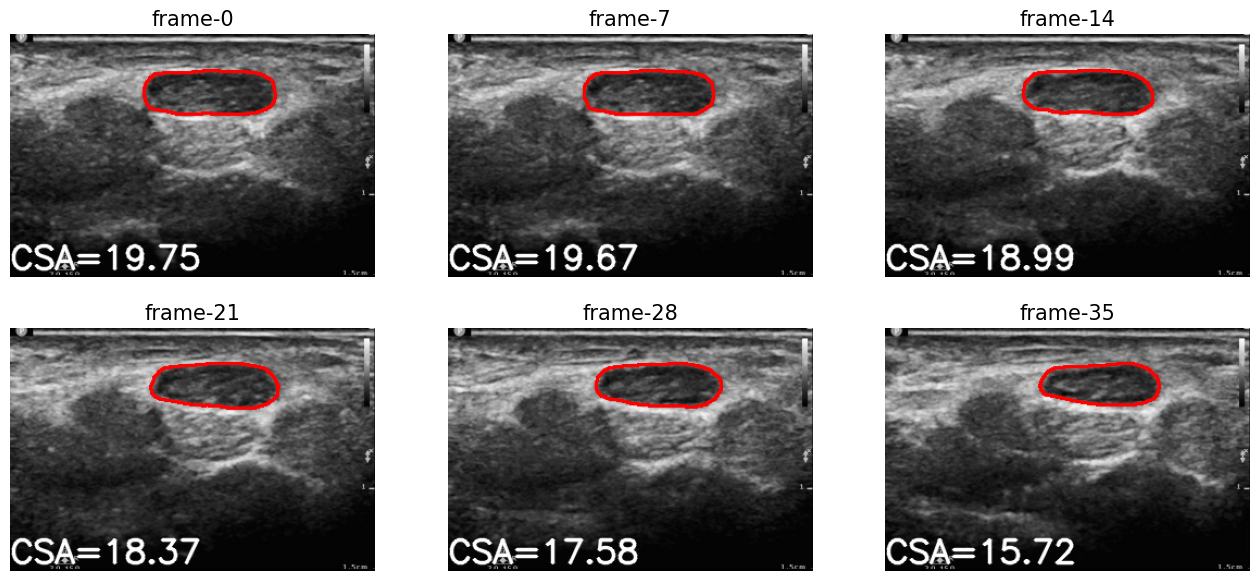

In [186]:
num = 2
output, vid_length = test_model(img_path, num, model, n_frames= 36)

clip = img_path[num]
op = []

for i in tqdm(range(len(output))):
    
    img = Image.open(clip[i]) #frame

#     msk = Image.open(test_msk_path[num][i]) #ground Truth
#     temp = create_pred_video(img, msk, 'GT') #Green
    out_frame = create_pred_video(img,output[i], 'Pred') #Red
    out_frame = out_frame[:224]

    area = np.sum(output[i])*const

    put_text(out_frame, f'CSA={round(area,2)}')
    op.append(out_frame)

l = np.linspace(0,len(op),6, endpoint=False)
l = [0,7,14,21,28,35]

plt.figure(figsize=(16,7))
# plt.figure(figsize=(16,13))
for i in range(len(l)):
    plt.subplot(2,3,i+1)
#     print(l[i])
    plt.axis("off")
    plt.imshow(cv2.cvtColor(op[int(l[i])][:224], cv2.COLOR_BGR2RGB))
    plt.title(f'frame-{int(l[i])}', fontsize=15)
plt.show()

In [ ]:
for frame in output:
    area = np.sum(frame)*const
    if not isinstance(frame, np.ndarray): frame = np.array(frame)
    if frame.dtype!='uint8': frame= (frame*255).astype(np.uint8)
    if(len(frame.shape)<3): frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)
    put_text(frame, f'CSA={round(area,2)}')

In [ ]:
plt.imshow(frame)

In [ ]:
area = np.sum(SR)*const
area

In [ ]:
SR.shape

In [ ]:
avg_res = np.round(avg_res,3)
avg_res2 = np.round(avg_res2,3)

In [ ]:
for i in range(len(avg_res)):
    print(f'{i+1} & {avg_res2[i][0]} & {avg_res2[i][1]}  & {avg_res2[i][3]} & {avg_res[i][0]} & {avg_res[i][1]}  & {avg_res[i][3]}')
print(f'mean & {np.mean(avg_res2[:,0])} & {np.mean(avg_res2[:,1])} & {np.mean(avg_res2[:,3])} & {np.mean(avg_res[:,0])} & {np.mean(avg_res[:,1])} & {np.mean(avg_res[:,3])}')

In [ ]:
for i,j in enumerate(test_file_dir):
    print(j,i)
num = 5

In [ ]:
file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/full/*'))

test_full_path = []

for path in file_dir:
    test_full_path.append(sorted(glob.glob(path+'/*_0001_IMAGES/images/*.jpg'), key=key_func))

In [ ]:
transform = T.Compose([
T.ToTensor(),
T.Normalize([0.2316], [0.2038]), #mean #standard deviation
#     AddGaussianNoise(mean=0., std=std)
])

output, vid_length = test_model(test_full_path, num, model, num_frames)
pred_masks_vistr = get_filtered_mask(output)

In [ ]:
with open('../TeViT-main/results.json', 'r') as f:
    full_data = json.load(f)
f.close()
pred_masks = []
for i, pred in enumerate(full_data):
#     assert pred['video_id'] == truth['video_id'] , "Video ID should match"
#     filename = data['video_id']
    temp = mask_utils.decode(pred['segmentations']).transpose((2,0,1))
    pred_masks += [msk for msk in temp]
pred_masks_tevit = get_filtered_mask(pred_masks)

In [ ]:
with open('pred_results_lstm.json', 'r') as f:
    full_data = json.load(f)
f.close()
pred_masks_lstm = []

temp = mask_utils.decode(full_data['144344']).transpose((2,0,1))
pred_masks_lstm += [msk for msk in temp]
# pred_masks_lstm = get_filtered_mask(pred_masks_lstm)


In [ ]:
clip = test_full_path[num]
frameSize = (336*3, 448) # width x height
fourcc = cv2.VideoWriter_fourcc(*'XVID')
name = test_file_dir[num].split('/')[-1].split('_')[-1]
out = cv2.VideoWriter(f'{name}_filter.avi', 
                      fourcc, 15,
                      frameSize,)
#                       isColor = False)

for i in range(len(pred_masks_tevit)):
    tmp = np.zeros((448, 336*3,3)).astype(np.uint8)
    
    img = Image.open(clip[i]) #frame
    
    if i < len(test_msk_path[num]):
        msk = Image.open(test_msk_path[num][i]) #ground Truth
        temp = create_pred_video(img, msk, 'GT') #Green
        temp2 = create_pred_video(img, msk, 'GT') #Green
        temp3 = create_pred_video(img, msk, 'GT') #Green
        out_frame = create_pred_video(temp,pred_masks_vistr[i], 'Pred') #Red
        out_frame2 = create_pred_video(temp2,pred_masks_tevit[i], 'Pred') #Red
        out_frame3 = create_pred_video(temp3,pred_masks_lstm[i], 'Pred') #Red
    else:
        out_frame = create_pred_video(img,pred_masks_vistr[i], 'Pred') #Red
        out_frame2 = create_pred_video(img,pred_masks_tevit[i], 'Pred') #Red
        out_frame3 = create_pred_video(img,pred_masks_lstm[i], 'Pred') #Red
#     out_frame = create_pred_video(temp,pred_mask[0][i], 'Pred') #Red
    put_text(out_frame, 'VisTR')
    put_text(out_frame2, 'TeViT')
    put_text(out_frame3, 'LSTM V1')
    tmp[:,:336,:] = out_frame
    tmp[:,336:336*2,:] = out_frame2
    tmp[:,336*2:,:] = out_frame3
    out.write(tmp)

out.release()
print(name)

In [ ]:
plt.imshow(cv2.putText(out_frame,
        'VisTR', (0, 440),
        0,
        1,
        color =(255, 255, 255),
        thickness=2,
        lineType=cv2.LINE_AA))

In [185]:
# file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/NORMAL WRIST MEDIAN 1.5CM/*'))
file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/SEVERE CTS WRIST 1.5CM/*'))
# file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/CTS 1.5CM AND 3CM/*'))
# file_dir = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/full/*'))[:1]

img_path = []
msk_path = []

for path in file_dir:
#     img_path.append(sorted(glob.glob(path+'/*.jpg'), key=key_func))
    img_path.append(sorted(glob.glob(path+'/frames/*.jpg'), key=key_func))
#     img_path.append(sorted(glob.glob(path+'/frames2/*.jpg'), key=key_func))
#     img_path.append(sorted(glob.glob(path+'/*_0001_IMAGES/*.jpg'), key=key_func))
len(img_path)

22

In [ ]:
Image.open(img_path[0][76]).size

In [ ]:
test_res = []
pred_mask = []
for num in tqdm(range(len(img_path))):
    start = time.time()
    output, vid_length = test_model(img_path, num, model, n_frames = 36)
    end = time.time()
#     print(vid_length/(end-start))
#     break
    pred_mask.append(output)
    print(vid_length/(end-start))
    break

In [ ]:
plt.imshow(pred_mask[0][0])

In [ ]:
pred_mask[0][0].shape

In [ ]:
res = {}
for i in range(len(file_dir)):
    name = file_dir[i].split('/')[-1]
    
    masks = np.array(pred_mask[i]).transpose((1,2,0))
    masks = np.array(masks, order='F', dtype='uint8')
    masks = mask_utils.encode(masks)
    for msk in masks:
        msk['counts'] = msk['counts'].decode()
    res[name] = masks

In [ ]:
json.dump(res, open('pred_results_NWM.json', 'w'))

In [ ]:
vid_num = 1
name = file_dir[vid_num].split('/')[-1]
frameSize = (336, 448) # width x height
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(str(vid_num)+'_'+name+'.avi', 
                      fourcc, 15,
                      frameSize,)
#                       isColor = False)

for i in range(len(img_path[vid_num])):
    
    img = Image.open(img_path[vid_num][i]) #frame
    out_frame = create_pred_video(img,pred_mask[vid_num][i], 'Pred')
    out.write(out_frame)

out.release()

In [ ]:
x = Image.open(test_img_path[num][0])
y = Image.open(test_msk_path[num][0])
# create_pred_video

In [ ]:
paths = sorted(glob.glob('../Dissertation/aster_updated_data_22_01_2022/full/*'))
test_full_vid = []
for path in paths:
    test_full_vid.append(sorted(glob.glob(path + '/*_0001_IMAGES/images/*.jpg'), key=key_func))
# test_full_vid

In [ ]:
# Convert image shape into 448,336
for img_paths in tqdm(test_full_vid, total=len(test_full_vid)):
    for img_path in img_paths:
#         print(img_path)
#         break
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != (448,336):
            cv2.imwrite(img_path, img[4:452,3:339])

In [ ]:
p_mask = []
start = time.time()
for num in tqdm(range(len(test_full_vid))):
    output = test_model(test_full_vid, num, model, n_frames = 36)
    p_mask.append(output)
    
end = time.time()
print('time taken:',end-start)

In [ ]:
len(test_full_vid[0])/(end-start)

In [ ]:
start = time.time()
start

In [ ]:
frameSize = (336, 448) # width x height
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_VisTR_144344_full.avi', 
                      fourcc, 15,
                      frameSize,)
#                       isColor = False)

for i in range(len(test_full_vid[0])):
    
    img = Image.open(test_full_vid[0][i]) #frame
#     msk = Image.open(test_msk_path[5][i]) #ground Truth
#     temp = create_pred_video(img, msk, 'GT')
    out_frame = create_pred_video(img,p_mask[0][i], 'Pred')
    out.write(out_frame)

out.release()

In [ ]:
def get_frames(path):
    # Read the video from specified path
    frame_list = []
    cam = cv2.VideoCapture(path)
    nw = []
    while(True):
        # reading from frame
        ret,frame = cam.read()
        if ret:
            frame_list.append(frame)
        else:
            break
    return frame_list

In [ ]:
import cv2
import os
  
nw = get_frames("10_NOR0016_WRIST-N_20221122_121300.avi")
cts = get_frames("5_005_CTS_20221031_133239.avi")
s_cts = get_frames("5_SEV0015_WRIST-CTS_20230109_145944.avi")
print(len(nw), len(cts), len(s_cts))

In [ ]:
frameSize = (336*3, 448) # width x height
fourcc = cv2.VideoWriter_fourcc(*'XVID')
name = 'Classification'
out = cv2.VideoWriter(f'{name}.avi', 
                      fourcc, 5,
                      frameSize,)
#                       isColor = False)

for i in range(min(len(nw), len(cts), len(s_cts))):
    tmp = np.zeros((448, 336*3,3)).astype(np.uint8)
    
    put_text(nw[i], 'Normal Wrist')
    put_text(cts[i], 'Mild CTS')
    put_text(s_cts[i], 'Severe CTS')
    tmp[:,:336,:] = nw[i]
    tmp[:,336:336*2,:] = cts[i]
    tmp[:,336*2:,:] = s_cts[i]
    out.write(tmp)

out.release()
print(name)